In [1]:
!pip install autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 14.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import time

from tqdm import tqdm

sns.set()
tf.random.set_seed(1929)

%matplotlib inline

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

dataset_train = tf.data.Dataset.from_tensor_slices((tf.cast(x_train/255, tf.float32),
                                                    tf.cast(y_train/255, tf.int64))).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((tf.cast(x_test/255, tf.float32),
                                                   tf.cast(y_test/255, tf.int64))).batch(64)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(1000, activation='relu', use_bias=False),
    tf.keras.layers.Dense(1000, activation='relu', use_bias=False),
    tf.keras.layers.Dense(500, activation='relu', use_bias=False),
    tf.keras.layers.Dense(200, activation='relu', use_bias=False),
    tf.keras.layers.Dense(10, use_bias=False)
])

In [5]:
#Model Training

optimizer = tf.keras.optimizers.Adam()
global_step = tf.Variable(0, trainable=False)

training_losses = []
training_accuracies = []

for epoch in range(10):
  # For calculating avg loss per epoch
  epoch_loss_avg = tf.keras.metrics.Mean()
  # SparseCategoricalAccuracy is used for classification tasks with integer labels.
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  for x, y in tqdm(dataset_train, total=round(len(x_train) / 64)):
    with tf.GradientTape() as tape:
      outputs = model(x, training=True)
      loss = tf.keras.losses.sparse_categorical_crossentropy(y, outputs)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    global_step.assign_add(1)

    epoch_loss_avg.update_state(loss)
    epoch_accuracy.update_state(y, outputs)

  training_losses.append(epoch_loss_avg.result().numpy())
  training_accuracies.append(epoch_accuracy.result().numpy())

  print(f'Epoch {epoch + 1} - Loss: {epoch_loss_avg.result().numpy()} - Accuracy: {epoch_accuracy.result().numpy()}')


100%|██████████| 938/938 [00:28<00:00, 32.80it/s]


Epoch 1 - Loss: 0.014684014953672886 - Accuracy: 0.9989333152770996


100%|██████████| 938/938 [00:16<00:00, 55.68it/s]


Epoch 2 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:16<00:00, 56.04it/s]


Epoch 3 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:17<00:00, 54.78it/s]


Epoch 4 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:16<00:00, 56.12it/s]


Epoch 5 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:18<00:00, 50.22it/s]


Epoch 6 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:17<00:00, 54.50it/s]


Epoch 7 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:20<00:00, 45.84it/s]


Epoch 8 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:16<00:00, 56.00it/s]


Epoch 9 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


100%|██████████| 938/938 [00:16<00:00, 55.22it/s]

Epoch 10 - Loss: 1.0728834922701935e-06 - Accuracy: 1.0


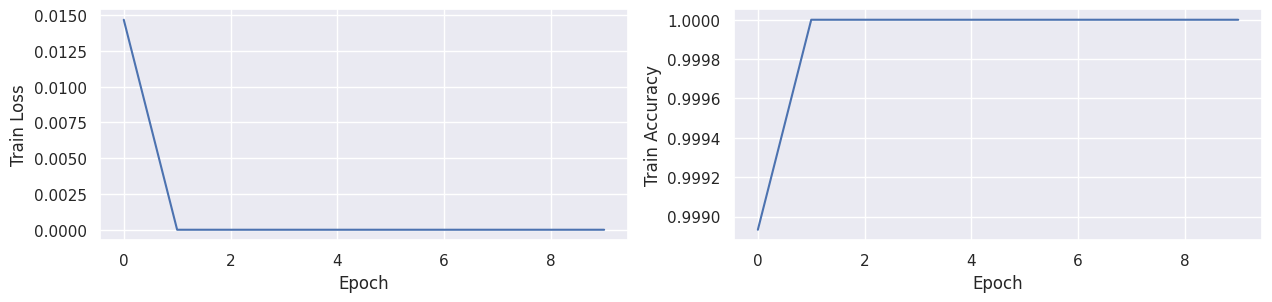

In [6]:
plt.figure(1, figsize=(15, 3))

plt.subplot(121)
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.subplot(122)
plt.plot(training_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')

plt.show()

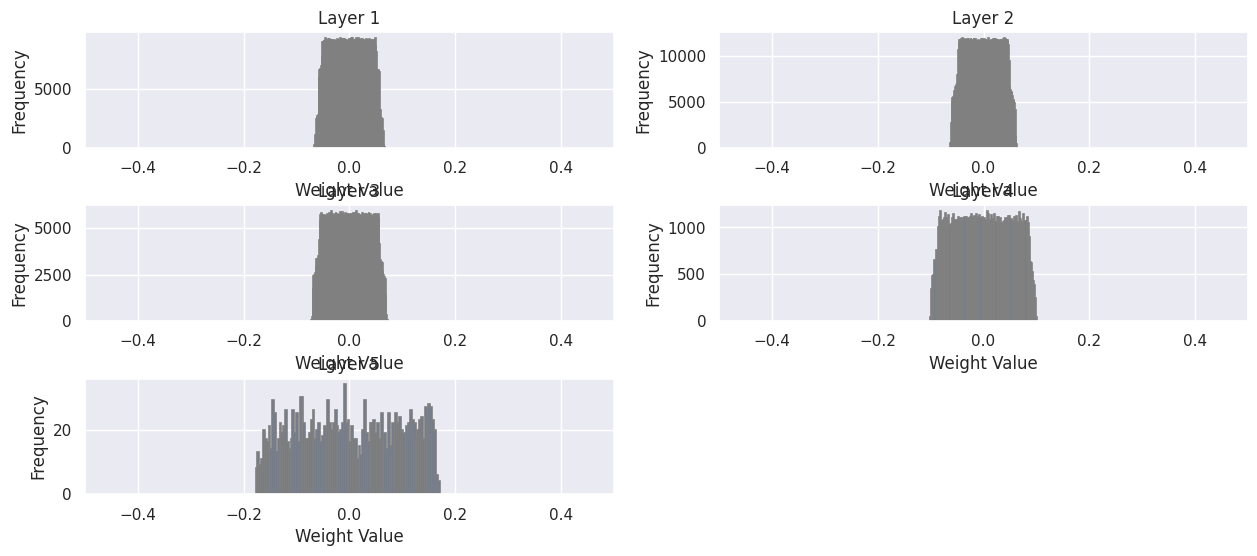

In [8]:
import matplotlib.pyplot as plt

# Plot histogram of each layer's weights (for weight pruning)
plt.figure(1, figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

# Iterate over the model's trainable weights
for i, weights in enumerate(model.trainable_weights):
    plt.subplot(3, 2, i + 1)  # Create a subplot for each layer's weights
    plt.title("Layer {}".format(i + 1))  # Set the title for each subplot

    # Plot the histogram of the weights with thick edges
    plt.hist(weights.numpy().reshape(-1), bins=100, edgecolor='gray', linewidth=1.2)

    plt.xlim(-0.5, 0.5)  # Set the x-axis limits
    plt.xlabel('Weight Value')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis

# Display the plots
plt.show()


In [12]:
import tensorflow as tf

def test(model, dataset):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.Accuracy()

    for x, y in dataset:
        # Forward pass
        outputs = model(x, training=False)

        # Compute the loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(y, outputs)

        # Update the metrics
        epoch_loss_avg.update_state(loss)
        epoch_accuracy.update_state(tf.argmax(outputs, axis=1, output_type=tf.int64), y)

    return epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()

test(model, dataset_test)


(1.0728835e-06, 1.0)

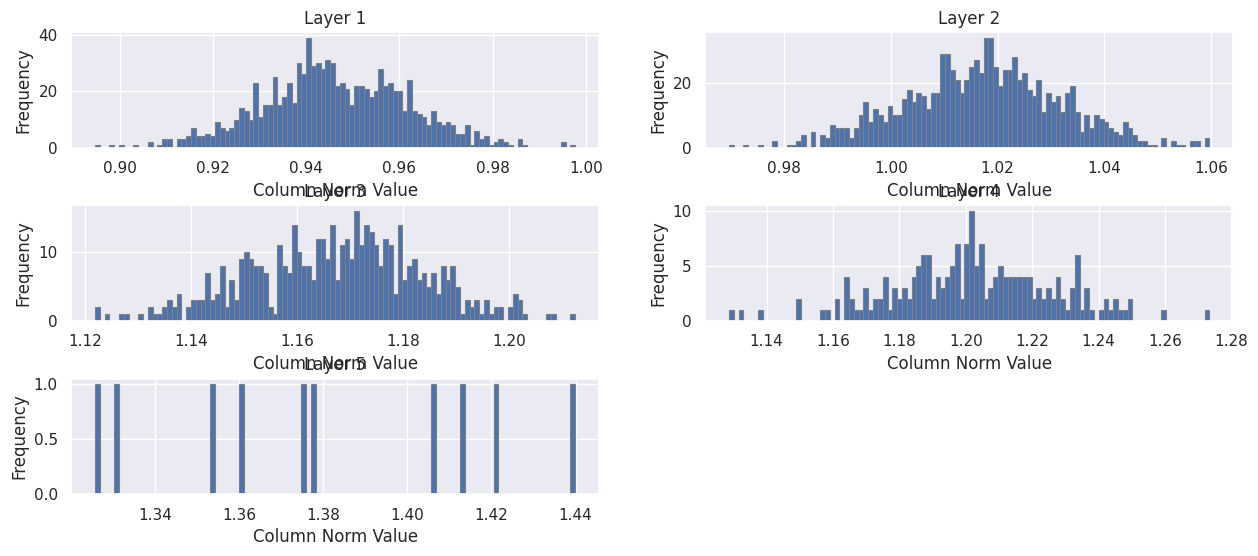

In [23]:
# Plot histogram of each layer's column norms (for unit pruning)
plt.figure(2, figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    # Calculate the L2 norm of the columns of the weight matrix
    column_norms = np.linalg.norm(weights.numpy(), ord=2, axis=0)
    plt.subplot(3, 2, i + 1)  # Create a subplot for each layer's column norms
    plt.title("Layer {}".format(i + 1))  # Set the title for each subplot

    # Plot the histogram of the column norms with thick edges
    plt.hist(column_norms, edgecolor='gray', linewidth=0.8, bins=100)

    plt.xlabel('Column Norm Value')  # Label for the x-axis
    plt.ylabel('Frequency')  # Label for the y-axis

# Display the plots
plt.show()

In [18]:
percentiles = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [19]:
import tensorflow as tf
import numpy as np

# Define a custom TensorFlow Module for a Weight Sparse Model
class WeightSparseModel(tf.Module):
    def __init__(self, sparsify=True):
        super(WeightSparseModel, self).__init__()
        self.sparsify = sparsify
        self.flatten = tf.keras.layers.Flatten()  # Flatten layer to convert input data into 1D vector
        self.weights = []  # List to store weights of the model's layers

    def add_layer(self, weights):
        """
        Adds a layer's weights to the model.

        If `sparsify` is True, converts dense weights to sparse format.

        Args:
        - weights: The weights of the layer to be added.
        """
        if self.sparsify:
            weights = tf.sparse.from_dense(weights)  # Convert dense weights to sparse format
        self.weights.append(weights)  # Add weights to the model's weights list

    def __call__(self, dense_x, training=False):
        """
        Performs forward pass through the model.

        Args:
        - dense_x: Input data to be processed by the model.
        - training: Boolean flag indicating whether the model is in training mode.

        Returns:
        - dense_x: Processed output data after passing through the model.
        """
        dense_x = self.flatten(dense_x)  # Flatten the input data
        if self.sparsify:
            dense_x = tf.transpose(dense_x)  # Transpose the input if sparsifying weights (X^T)

        # Iterate through each layer's weights
        for i, weights in enumerate(self.weights):
            if self.sparsify:
                dense_x = tf.sparse.sparse_dense_matmul(weights, dense_x, adjoint_a=True)  # Sparse matrix multiplication (sL^T x X^T)
            else:
                dense_x = tf.matmul(dense_x, weights)  # Regular matrix multiplication

            if i < len(self.weights) - 1:
                dense_x = tf.nn.relu(dense_x)  # Apply ReLU activation except for the last layer

        if self.sparsify:
            dense_x = tf.transpose(dense_x)  # Transpose back if sparsifying weights (X == (X^T)^T)

        return dense_x  # Return processed output data

def prune_weights(dense_model, percentile, sparsify=True):
    """
    Prunes the weights of a dense model based on a specified percentile threshold.

    Args:
    - dense_model: The original dense model to be pruned.
    - percentile: The percentile threshold used for pruning (0 to 100).
    - sparsify: Boolean flag indicating whether to use sparse representations for weights.

    Returns:
    - sparse_model: A WeightSparseModel instance containing pruned weights.
    """
    sparse_model = WeightSparseModel(sparsify)  # Initialize a WeightSparseModel instance
    num_layers = len(dense_model.weights)  # Get the number of layers in the dense model

    # Iterate through each layer's weights in the dense model
    for i_layer, weights in enumerate(dense_model.weights):
        weights_np = weights.numpy()  # Convert TensorFlow weights to NumPy array

        if i_layer < num_layers - 1:  # Do not prune the last layer
            critical_value = np.percentile(np.abs(weights_np), percentile)  # Calculate percentile threshold
            zero_mask = np.abs(weights_np) < critical_value  # Create mask for weights below threshold
            weights_np[zero_mask] = 0  # Zero out weights below the threshold

        sparse_model.add_layer(weights_np)  # Add pruned weights to the sparse model

    return sparse_model  # Return the WeightSparseModel instance with pruned weights

# Example usage: Perform a sanity check by testing the pruned model
print(test(prune_weights(model, 90), dataset_test))


(1.0728835e-06, 1.0)


In [15]:
# Initialization: Four empty lists (pruned_weight_test_losses, pruned_weight_test_accuracies, pruned_weight_sparse_timings, pruned_weight_timings) are initialized to store results from the following loop iterations.
pruned_weight_test_losses = []
pruned_weight_test_accuracies = []
pruned_weight_sparse_timings = []
pruned_weight_timings = []

In [21]:
for percentile in percentiles:
    sparsified_model = prune_weights(model, percentile, True)
    t1 = time.time()
    l, a = test(sparsified_model, dataset_test)
    t1 = time.time() - t1

    pruned_model = prune_weights(model, percentile, False)
    t2 = time.time()
    l2, a2 = test(pruned_model, dataset_test)
    t2 = time.time() - t2

    # Sanity check - both weight pruning methods return same results
    np.testing.assert_almost_equal(l, l2)
    np.testing.assert_almost_equal(a, a2)

    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Sparse Timing Ratio: {(t1/t2):.2f} ({t1:.2f}s/{t2:.2f}s)")
    pruned_weight_test_losses.append(l)
    pruned_weight_test_accuracies.append(a)
    pruned_weight_sparse_timings.append(t1)
    pruned_weight_timings.append(t2)


Pruning p0 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.99 (3.69s/3.72s)
Pruning p25 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.38 (1.96s/5.11s)
Pruning p50 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.85 (1.70s/1.99s)
Pruning p60 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.74 (1.46s/1.98s)
Pruning p70 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 1.26 (2.55s/2.03s)
Pruning p80 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.69 (1.22s/1.76s)
Pruning p90 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.63 (1.17s/1.87s)
Pruning p95 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.46 (1.18s/2.55s)
Pruning p97 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.41 (1.16s/2.81s)
Pruning p99 -- Test Loss: 0.0001, Test Accuracy: 1.0000, Sparse Timing Ratio: 0.58 (1.16s/2.01s)


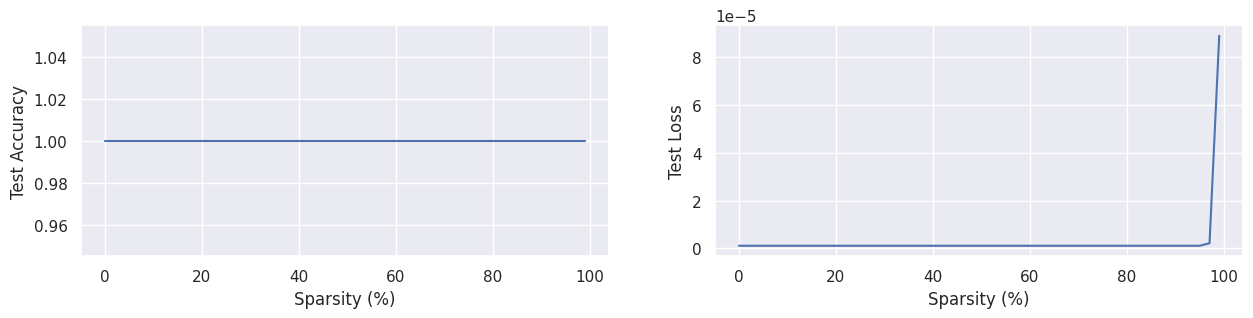

In [22]:
plt.figure(3, figsize=(15,3))
plt.subplot(121)
plt.plot(percentiles, pruned_weight_test_accuracies)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.subplot(122)
plt.plot(percentiles, pruned_weight_test_losses)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss');

In [24]:
def unit_prune(dense_model, percentile): # Norm-based pruning
    prev_kept_columns = None  # Variable to keep track of columns kept from the previous layer
    pruned_model = tf.keras.models.Sequential()  # Initialize a sequential model
    pruned_model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))  # Add a flatten layer to the model (assume input shape is 28x28)
    num_layers = len(dense_model.trainable_weights)  # Get the number of trainable layers in the dense model

    for i_layer, weights in enumerate(dense_model.trainable_weights):
        weights_np = weights.numpy()  # Convert the weights to a numpy array

        # Remove pruned columns (neurons)
        if i_layer < num_layers-1:  # Do not prune the last layer
            column_norms = np.linalg.norm(weights_np, ord=2, axis=0)  # Calculate the L2 norm of each column
            critical_value = np.percentile(column_norms, percentile)  # Determine the percentile threshold for pruning
            keep_mask = column_norms >= critical_value  # Create a mask for columns to keep
            weights_np = weights_np[:, keep_mask]  # Keep only the columns that are above the threshold

        # Remove rows corresponding to the previous layer's pruned columns
        if prev_kept_columns is not None:
            weights_np = weights_np[prev_kept_columns, :]  # Keep only the rows that correspond to previously kept columns

        # Record which columns were kept for the current layer
        if i_layer < num_layers-1:  # No pruned columns in the last layer
            prev_kept_columns = np.argwhere(keep_mask).reshape(-1)  # Record the indices of columns that were kept

        # Add a new dense layer to the pruned model with the pruned weights
        new_layer = tf.keras.layers.Dense(weights_np.shape[1], activation=tf.nn.relu, use_bias=False)
        pruned_model.add(new_layer)
        new_layer.set_weights([weights_np])  # Set the weights of the new layer to the pruned weights

    return pruned_model  # Return the pruned model


In [25]:
pruned_unit_test_losses = []
pruned_unit_test_accuracies = []
pruned_unit_timings = []

for percentile in percentiles:
    sparse_model = unit_prune(model, percentile)
    t = time.time()
    l, a = test(sparse_model, dataset_test)
    t = time.time() - t
    print(f"Pruning p{percentile} -- Test Loss: {l:.4f}, Test Accuracy: {a:.4f}, Timing: {t:.2f}s")
    pruned_unit_test_losses.append(l)
    pruned_unit_test_accuracies.append(a)
    pruned_unit_timings.append(t)

Pruning p0 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Timing: 1.49s
Pruning p25 -- Test Loss: 0.0000, Test Accuracy: 1.0000, Timing: 1.44s
Pruning p50 -- Test Loss: 0.0085, Test Accuracy: 1.0000, Timing: 1.25s
Pruning p60 -- Test Loss: 0.0111, Test Accuracy: 1.0000, Timing: 1.24s
Pruning p70 -- Test Loss: 0.2784, Test Accuracy: 1.0000, Timing: 1.28s
Pruning p80 -- Test Loss: 1.1579, Test Accuracy: 0.0001, Timing: 2.55s
Pruning p90 -- Test Loss: 1.0286, Test Accuracy: 0.9899, Timing: 1.24s
Pruning p95 -- Test Loss: 0.8434, Test Accuracy: 1.0000, Timing: 1.24s
Pruning p97 -- Test Loss: 0.7884, Test Accuracy: 1.0000, Timing: 1.23s
Pruning p99 -- Test Loss: 0.7959, Test Accuracy: 1.0000, Timing: 1.19s


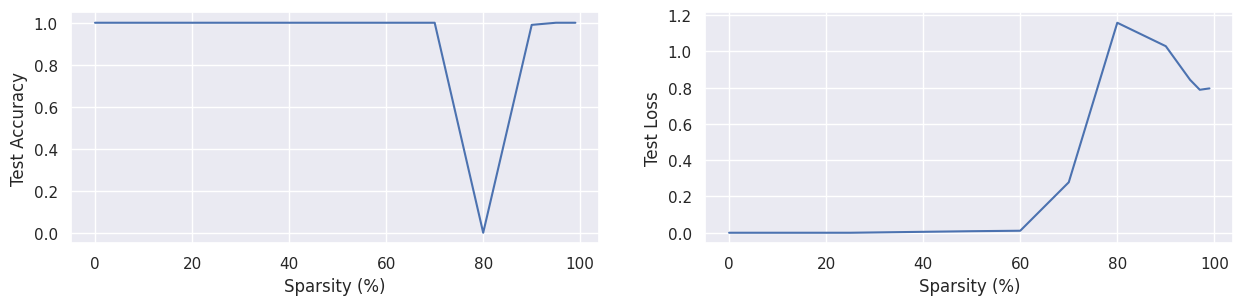

In [26]:
plt.figure(4, figsize=(15,3))
plt.subplot(121)
plt.plot(percentiles, pruned_unit_test_accuracies)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.subplot(122)
plt.plot(percentiles, pruned_unit_test_losses)
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss');

In [28]:
#Result analysis

pd.options.display.float_format = '{:.4f}'.format
pd.DataFrame(data={
    'Percent Sparsity':percentiles,
    'Test Accuracy (Unit Pruned)': pruned_unit_test_accuracies,
    'Test Accuracy (Weight Pruned)': pruned_weight_test_accuracies
})

,Percent Sparsity,Test Accuracy (Unit Pruned),Test Accuracy (Weight Pruned)
0,0,1.0000,1.0000
1,25,1.0000,1.0000
2,50,1.0000,1.0000
3,60,1.0000,1.0000
4,70,1.0000,1.0000
5,80,0.0001,1.0000
6,90,0.9899,1.0000
7,95,1.0000,1.0000
8,97,1.0000,1.0000
9,99,1.0000,1.0000


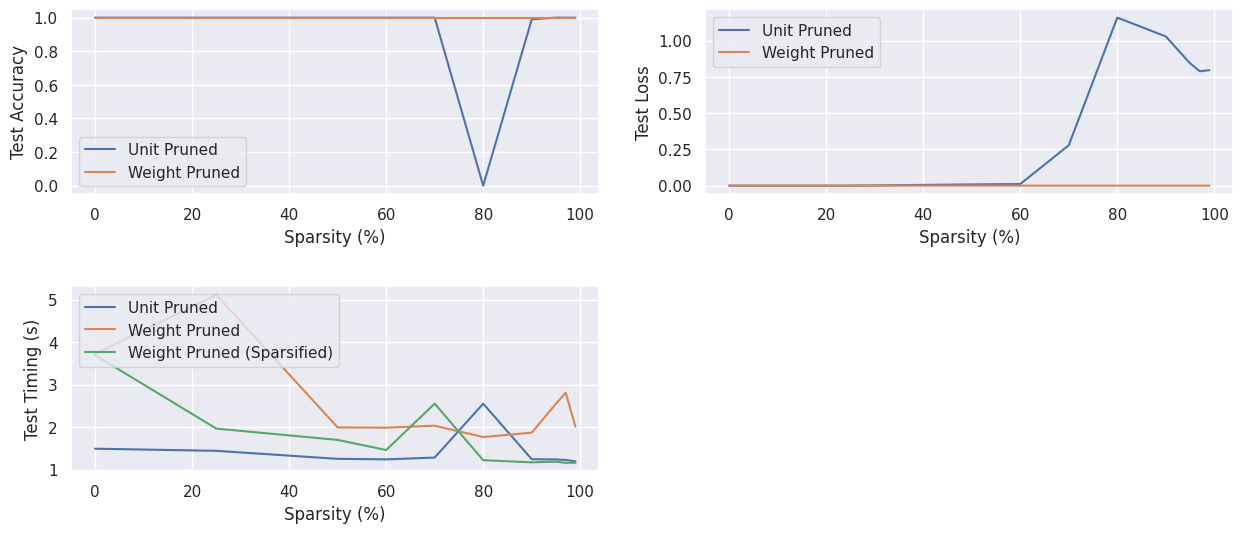

In [27]:
plt.figure(5, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
plt.subplot(221)
plt.plot(percentiles, pruned_unit_test_accuracies, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_test_accuracies, label='Weight Pruned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower left')
plt.subplot(222)
plt.plot(percentiles, pruned_unit_test_losses, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_test_losses, label='Weight Pruned')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Loss')
plt.legend(loc='upper left')
plt.subplot(223)
plt.plot(percentiles, pruned_unit_timings, label='Unit Pruned')
plt.plot(percentiles, pruned_weight_timings, label='Weight Pruned')
plt.plot(percentiles, pruned_weight_sparse_timings, label='Weight Pruned (Sparsified)')
plt.xlabel('Sparsity (%)')
plt.ylabel('Test Timing (s)')
plt.legend(loc='upper left');

In [30]:
'''
Results:

Weight pruning generally maintains higher test accuracy than unit pruning as sparsity increases.
At lower levels of sparsity, both methods perform similarly, but unit pruning's performance drops significantly at higher sparsity levels.
Weight pruning remains relatively robust up to 80% sparsity, after which its accuracy also declines.
'''

"\nResults: \n\nWeight pruning generally maintains higher test accuracy than unit pruning as sparsity increases. \nAt lower levels of sparsity, both methods perform similarly, but unit pruning's performance drops significantly at higher sparsity levels. \nWeight pruning remains relatively robust up to 80% sparsity, after which its accuracy also declines.\n"